In [1]:
import cv2
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import os
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from timm.models.efficientnet import efficientnet_b0, efficientnet_b1, \
efficientnet_b2, efficientnet_b3, efficientnet_b4, efficientnet_b5, \
efficientnet_b6, efficientnet_b7
import torch
from torch import nn
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.pooling import AdaptiveAvgPool2d
from sklearn.metrics import accuracy_score
from ptflops.flops_counter import get_model_complexity_info
from functools import partial

from log import Log
from deep_fake_classifier_dataset import DeepFakeClassifierDataset

In [2]:
encoder_inits = {
    'efficientnet_b0':partial(efficientnet_b0, pretrained=True),
    'efficientnet_b1':partial(efficientnet_b1, pretrained=True),
    'efficientnet_b2':partial(efficientnet_b2, pretrained=True),
    'efficientnet_b3':partial(efficientnet_b3, pretrained=True),
    'efficientnet_b4':partial(efficientnet_b4, pretrained=True),
    'efficientnet_b5':partial(efficientnet_b5, pretrained=True),
    'efficientnet_b6':partial(efficientnet_b6, pretrained=True),
    'efficientnet_b7':partial(efficientnet_b7, pretrained=True),
}

In [3]:
class DeepFakeClassifier(nn.Module):
    def __init__(self, encoder, encoder_features, dropout_rate=0.0):
        super().__init__()
        self.encoder = encoder
        self.avg_pool = AdaptiveAvgPool2d((1, 1))
        self.dropout = Dropout(dropout_rate)
        self.fc = Linear(encoder_features, 1)

    def forward(self, x):
        x = self.encoder.forward_features(x)
        x = self.avg_pool(x).flatten(1)
        x = self.dropout(x)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x
    
    def freeze_encoder(self):
        self.encoder.eval()
        for p in self.encoder.parameters():
            p.requires_grad = False
    
    def unfreeze_encoder(self):
        self.encoder.train()
        for p in self.encoder.parameters():
            p.requires_grad = True

In [12]:
def train_epoch(model, optimizer, loss_functions, train_data_loader, history):
    for imgs, labels, *_ in train_data_loader:
        imgs = imgs.type(torch.float).cuda()
        labels = labels.type(torch.float).reshape(-1, 1).cuda()
        optimizer.zero_grad()
        label_predicted = model(imgs)
        loss = loss_functions(label_predicted, labels)
        loss.backward()
        optimizer.step()
        history.append(np.mean(loss.cpu().detach().numpy()))

In [13]:
def confident_strategy(pred, t=0.8):
    pred = np.array(pred)
    sz = len(pred)
    fakes = np.count_nonzero(pred > t)
    # 11 frames are detected as fakes with high probability
    if fakes > sz // 2.5 and fakes > 11:
        return np.mean(pred[pred > t])
    elif np.count_nonzero(pred < 0.2) > 0.9 * sz:
        return np.mean(pred[pred < 0.2])
    else:
        return np.mean(pred)

In [14]:
def evaluate_classifier(model, data, metric, average_prediction=None, log=None):
    model.eval()
    
    predicted_frame_labels = {}
    labels = {}
    for vid in data.metadata['vid'].unique():
        predicted_frame_labels[vid] = []
        labels[vid] = int(data.metadata[data.metadata['vid'] == vid]['label'].iloc[0])

    data_loader = DataLoader(data)
    iterable = log.tqdm(data_loader, 'Evaluating') if log is not None else tqdm(data_loader)
    for img, label, vid, cid in iterable:
        img = img.type(torch.float).cuda()
        predicted_label = model(img).cpu().detach().numpy()
        predicted_frame_labels[vid[0]].append(predicted_label)
    input_size = img.cpu().detach().numpy().shape[1:]
    
    predicted_labels = {}
    if average_prediction is not None:
        for vid in predicted_frame_labels:
            predicted_labels[vid] = int(average_prediction(predicted_frame_labels[vid]) >= 0.5)
    else:
        for vid in predicted_frame_labels:
            predicted_labels[vid] = int(np.mean(predicted_frame_labels[vid]) >= 0.5)
            
    score = metric(list(labels.values()), list(predicted_labels.values()))
    
    if getattr(model, 'compute_average_flops_cost', None) is not None:
        macs, params = model.compute_average_flops_cost()
    else:
        macs, params = get_model_complexity_info(model, input_size,
                                                 print_per_layer_stat=False,
                                                 as_strings=False)
    
    return score, macs, params

In [42]:
def estimate_classifiers(data_train, data_test, classifier, classifier_params, encoders,
                         loss_function, metric, batch_size, epochs, freeze_epochs=None,
                         average_prediction=None, save_models=False):
    log = Log()
    log.log('{:-^70}'.format('Estimating {} classifiers'.format(len(encoders))))
    summary = []
    for encoder_id in encoders:
        log.log('{:-^70}'.format(encoder_id))
        encoder = encoder_inits[encoder_id]().cuda()
        encoder_features = encoder.num_features
        model = classifier(encoder, encoder_features, *classifier_params).cuda()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
        loss_function = loss_function.cuda()
        log.log('Initialized')
        
        history = []
        mean_dur = 0
        model.train()
        if freeze_epochs is not None and freeze_epochs != 0:
            model.freeze_encoder()

        for epoch in log.tqdm(range(epochs), 'Training'):
            if epoch == freeze_epochs:
                model.unfreeze_encoder()

            train_data_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True,
                                           drop_last=True)

            train_epoch(model, optimizer, loss_function, train_data_loader, history)
        fig, ax = plt.subplots(figsize=(10, 1.5))
        ax.plot(history)
        plt.show()
        log.log('Loss: {}'.format(history[-1]))
        
        score, macs, params = evaluate_classifier(model, data_test, metric,
                                                  average_prediction=average_prediction,
                                                  log=log)
        log.log("Score:     {}\nMACs(B):   {}\nParams(M): {}".format(
            round(score, 6), round(macs/10**9, 3), round(params/10**6, 3)))
        
        summary.append({'encoder':encoder_id, 'score':score, 'macs':macs, 'params':params,
                       'history':history})
        
        if save_models:
            save_time = int(time.time())
            torch.save(model, os.path.join(models_path,
                                           "{}_{}_model.pth".format(save_time, encoder_id)))
            torch.save({'state_dict': model.state_dict()},
                       os.path.join(models_path,
                                    "{}_{}_state_dict.pth".format(save_time, encoder_id)))
            log.log('Saved')
    log.log('{:-^70}'.format('Complete'))
    return summary

In [43]:
data_path = "original_data"
processed_data_path = "processed_data"
models_path = "models"
image_size = 380

In [47]:
encoders = ['efficientnet_b0', 'efficientnet_b1']
batch_size = 4
epochs = 10
freeze_epochs = 3
dropout_rate = 0.15
learning_rate = 0.0002

In [48]:
metadata_train = pd.read_csv(os.path.join(processed_data_path, 'train.csv'))
metadata_test = pd.read_csv(os.path.join(processed_data_path, 'test.csv'))

#Костыль для тестов
idx = np.arange(len(metadata_train))
np.random.shuffle(idx)
part = metadata_train.loc[idx[:64]].reset_index()
part = part[part.columns[1:]]
#Конец костыля

data_train = DeepFakeClassifierDataset(part, processed_data_path, image_size, mode='train')

#Костыль
idx = np.arange(len(metadata_test))
np.random.shuffle(idx)
part = metadata_test.loc[idx[:64]].reset_index()
part = part[part.columns[1:]]
#Конец костыля

data_test = DeepFakeClassifierDataset(part, processed_data_path, image_size, mode='test')

0:00:00 -----------------------Estimating 2 classifiers-----------------------
0:00:00 ---------------------------efficientnet_b0----------------------------
0:00:00 Initialized


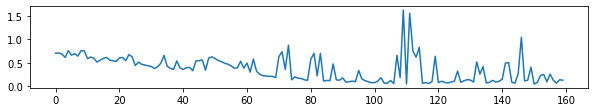

0:00:41 Loss: 0.12219859659671783



0:00:45 Score:     0.825397
0:00:45 MACs(B):   1.17
0:00:45 Params(M): 5.29
0:00:46 Saved
0:00:46 ---------------------------efficientnet_b1----------------------------
0:00:46 Initialized


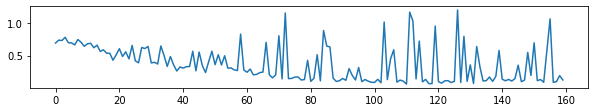

0:01:33 Loss: 0.12627620995044708



0:01:35 Score:     0.84127
0:01:35 MACs(B):   1.726
0:01:35 Params(M): 7.795
0:01:36 Saved
0:01:36 -------------------------------Complete-------------------------------


In [49]:
summary = estimate_classifiers(data_train, data_test, classifier=DeepFakeClassifier, 
                     classifier_params=(dropout_rate,), encoders=encoders, 
                     loss_function=torch.nn.BCELoss(), metric=accuracy_score,
                     batch_size=batch_size, epochs=epochs, freeze_epochs=freeze_epochs,
                     average_prediction=confident_strategy, save_models=True)